In [1]:
import math
#%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import json
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.applications.resnet_v2 import decode_predictions
from IPython.display import Image, display
from IPython.display import Image, display
import keras

In [2]:
%cd /content/drive/MyDrive/cnn_embed/cnn_manifold

/content/drive/MyDrive/cnn_embed/cnn_manifold


In [3]:
!git config --global user.email "aliciaxiaozeng@gmail.com"
!git config --global user.name "alicialitrtwe"

In [20]:
!git add .

In [21]:
!git commit -m 'visualize for any direction'

[main 9c1d457] visualize for any direction
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite activation_visualization.ipynb (75%)


In [22]:
!git push origin main

Counting objects: 10, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (10/10), done.
Writing objects: 100% (10/10), 104.09 KiB | 9.46 MiB/s, done.
Total 10 (delta 5), reused 0 (delta 0)
remote: Resolving deltas: 100% (5/5), completed with 1 local object.
To https://github.com/alicialitrtwe/cnn_manifold.git
   31255c3..9c1d457  main -> main


In [23]:
# TODO proper reception field size
# TODO image initiation does not work for inception deeper layers
# TODO optimization steps

In [3]:
layer_name = "conv3_block4_out"
model = tf.keras.applications.ResNet50V2(weights="imagenet", include_top=False)
#layer_name = "mixed3"
#model = tf.keras.applications.InceptionV3(weights="imagenet", include_top=False)
layer = model.get_layer(name=layer_name)
activation_model = tf.keras.models.Model(inputs=model.inputs, outputs=layer.output)


In [4]:
directions = np.zeros((10, 512))

In [5]:
import time
def measure():
  start = time.time()
  loss_all_direction_list = []
  visualization_list = []
  for i in range(len(directions)):  
    loss_list, img_list, processed_img_list = visualize_filter(directions[i], activation_model, n_iter=200, learning_rate=1)
    loss_all_direction_list.append(loss_list)
    visualization_list.append(processed_img_list)  
  end = time.time()
  return end - start

In [8]:
with tf.device("/cpu:0"):
  print("CPU: {} secs".format(measure()))

# Run on GPU, if available:
if tf.config.list_physical_devices("GPU"):
  with tf.device("/gpu:0"):
    print("GPU: {} secs".format(measure()))
else:
  print("GPU: not found")

i = 0
i = 100
i = 0
i = 100
i = 0
i = 100
i = 0
i = 100
i = 0
i = 100
i = 0
i = 100
i = 0
i = 100
i = 0
i = 100
i = 0
i = 100
i = 0
i = 100
i = 0
i = 100
i = 0
i = 100
i = 0
i = 100
i = 0
i = 100
i = 0
i = 100
i = 0
i = 100
i = 0
i = 100
i = 0
i = 100
i = 0
i = 100
i = 0
i = 100
CPU: 1140.0536739826202 secs
i = 0
i = 100
i = 0
i = 100
i = 0
i = 100
i = 0
i = 100
i = 0
i = 100
i = 0
i = 100
i = 0
i = 100
i = 0
i = 100
i = 0
i = 100
i = 0
i = 100
i = 0
i = 100
i = 0
i = 100
i = 0
i = 100
i = 0
i = 100
i = 0
i = 100
i = 0
i = 100
i = 0
i = 100
i = 0
i = 100
i = 0
i = 100
i = 0
i = 100
GPU: 239.30303525924683 secs


In [7]:
def initialize_image(img_size):
    # We start from a gray image with some random noise
    img = tf.Variable(tf.random.normal([1, img_size, img_size, 3], 0, 0.01, tf.float32, seed=1))
    # ResNet50V2 expects inputs in the range [-1, +1].
    return img

def compute_loss(img, direction, activation_model, img_size=180, cos_sim=False, x=None, y=None):
    #TODO: batch
    acts = activation_model(img) 
    # visualize the neuron in the center of each layer
    shape = tf.shape(acts)
    x_ = shape[1] // 2 if x is None else x
    y_ = shape[2] // 2 if y is None else y
    filter_activation = acts[0, 2:-2, 2:-2, :]
    # TODO: cosine similarity
    if cos_sim==False:
        loss = -tf.reduce_mean(filter_activation*direction)
    return loss

def gradient_ascent_step(img, direction, activation_model, learning_rate, opt):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, direction, activation_model)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    opt.apply_gradients(zip([grads], [img]))
    loss = compute_loss(img, direction, activation_model)
    return loss, img

def visualize_filter(direction, activation_model, img_size=180, learning_rate=0.1, n_iter=100, n_attempts=2):
    
    # gradient ascent
    # img = initialize_image(img_size)
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    loss_list = []
    img_list = [] 
    processed_img_list = []
    for j in range(n_attempts):
        img = initialize_image(img_size)
        for i in range(n_iter):
            loss, img = gradient_ascent_step(img, direction, activation_model, learning_rate, opt)
            # Progress
            if (i % 100 == 0):
                print(f'i = {i}')
        # Decode the resulting input image
        processed_img = deprocess_image(img[0].numpy())
        loss_list.append(loss)
        img_list.append(img)
        processed_img_list.append(processed_img)
    return loss_list, img_list, processed_img_list

def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    # Center crop
    img = img[25:-25, 25:-25, :]

    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img

In [5]:
img_size = 180

In [9]:
direction0.dtype

dtype('float64')

In [4]:
direction0 = tf.zeros([1, 512], tf.float32)
#direction0 = np.random.random((1, 512))

In [11]:
loss_all_direction_list = []
visualization_list = []
for i in range(1): #len(directions)
    
    loss_list, img_list, = visualize_filter(direction0, activation_model, n_iter=12, learning_rate=0.05)
    loss_all_direction_list.append(loss_list)
    visualization_list.append(img)

i = 0
i = 0


ValueError: ignored

In [191]:
loss_list

[<tf.Tensor: shape=(), dtype=float32, numpy=-0.019179262>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.01866622>]

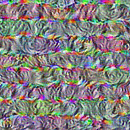

In [193]:
keras.preprocessing.image.save_img("0.png", processed_img_list[1])
display(Image("0.png"))

In [162]:
all_imgs = []
for filter_index in range(64):
    print("Processing filter %d" % (filter_index,))
    loss, img = visualize_filter(filter_index)
    all_imgs.append(img)

# Build a black picture with enough space for
# our 8 x 8 filters of size 128 x 128, with a 5px margin in between
margin = 5
n = 8
cropped_width = img_width - 25 * 2
cropped_height = img_height - 25 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

# Fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img = all_imgs[i * n + j]
        stitched_filters[
            (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
            (cropped_height + margin) * j : (cropped_height + margin) * j
            + cropped_height,
            :,
        ] = img
keras.preprocessing.image.save_img("stiched_filters.png", stitched_filters)

from IPython.display import Image, display

display(Image("stiched_filters.png"))

Processing filter 0


TypeError: ignored